In [1]:
%load_ext autoreload
%autoreload 2

from src.utils.helper import *
import pickle

with open('/Users/utkarsh/Documents/neural-toc/naacl_work/aviral_transformer_formal_language/models/shuffle6/vocab.p', 'rb') as f:
    vocab = pickle.load(f)
    
with open('/Users/utkarsh/Documents/neural-toc/naacl_work/aviral_transformer_formal_language/models/shuffle6/config.p', 'rb') as f:
    config = pickle.load(f)

In [2]:
from src.dataloader import *

data_path = 'data/Shuffle-6/train_corpus.pk'
with open(data_path, 'rb') as f:
    train_corpus = pickle.load(f)
    
train_loader = Sampler(train_corpus, vocab, 8)

src, _, wd_lens = train_loader.get_batch(0)
src.shape, wd_lens

['[]', '++()--', '[++a(<>)b--]', '(())', 'a{}b+{<>}[]-', '[a+<>-+-b]', '[{a({a<>b})b<<{+()-}>>}]', '+-']


(torch.Size([24, 8]), tensor([ 2,  6, 12,  4, 12, 10, 24,  2]))

In [3]:
def pad_seq(seq, max_length, voc):
    seq += [voc.get_id('T') for i in range(max_length - len(seq))]
    return seq

def sent_to_idx(voc, sent, max_length=-1):
    idx_vec = []
    for w in sent:
        idx = voc.get_id(w)
        idx_vec.append(idx)

    idx_vec.append(voc.get_id('T'))
    idx_vec = pad_seq(idx_vec, max_length+1, voc)
    return idx_vec

def sents_to_idx(voc, sents):
    max_length = max([len(s) for s in sents])
    all_indexes = []
    for sent in sents:
        all_indexes.append(sent_to_idx(voc, sent, max_length))

    all_indexes = torch.tensor(all_indexes, dtype= torch.long)
    return all_indexes

raw = train_corpus.source
data_ids = sents_to_idx(vocab, raw)
data = data_ids[:, :-1]
data.shape

torch.Size([10000, 100])

In [4]:
OPEN_CURLY = vocab.get_id('{')
CLOSE_CURLY = vocab.get_id('}')
OPEN_ROUND = vocab.get_id('(')
CLOSE_ROUND = vocab.get_id(')')
OPEN_SQUARE = vocab.get_id('[')
CLOSE_SQUARE = vocab.get_id(']')
OPEN_ANGLE = vocab.get_id('<')
CLOSE_ANGLE = vocab.get_id('>')
OPEN_PLUS = vocab.get_id('+')
CLOSE_PLUS = vocab.get_id('-')
OPEN_A = vocab.get_id('a')
CLOSE_B = vocab.get_id('b')

print(OPEN_CURLY, CLOSE_CURLY, OPEN_ROUND, CLOSE_ROUND, OPEN_SQUARE, CLOSE_SQUARE, OPEN_ANGLE, CLOSE_ANGLE, OPEN_PLUS, CLOSE_PLUS, OPEN_A, CLOSE_B)

PAIRINGS = {
    OPEN_ROUND: CLOSE_ROUND,
    OPEN_CURLY: CLOSE_CURLY,
    OPEN_SQUARE: CLOSE_SQUARE,
    OPEN_ANGLE: CLOSE_ANGLE,
    OPEN_PLUS: CLOSE_PLUS,
    OPEN_A: CLOSE_B
}

def simulate_stack(tokenised_paren):
    """
    Simulate stack operations for Dyck-4 language and compute stack depths.
    
    Args:
        tokenised_paren (list): List of tokens representing a sequence of parentheses.
    
    Returns:
        list: Stack depths at each token position.
    """
    stack = []
    stack_depths = []
    
    for token in tokenised_paren:
        token = token.item()
        # If the token is an opening parenthesis
        if token in PAIRINGS:
            stack.append(token)
        # If the token is a closing parenthesis
        elif token in PAIRINGS.values():
            if stack:
                top = stack.pop()
                # Check if the closing parenthesis matches the opening parenthesis
                if PAIRINGS[top] != token:
                    raise ValueError(f"Mismatched brackets: {top} and {token}")
            else:
                raise ValueError("Unmatched closing parenthesis")
        # Append the current stack depth
        stack_depths.append(len(stack))
    
    # Check for unmatched opening parentheses at the end
    if stack:
        raise ValueError("Unmatched opening parentheses remain in stack")
    
    return stack_depths

def create_dataset(model, paren_tokens, device="cpu"):
    X = []
    Y = []

    model.eval()

    with torch.no_grad():
        for tokenised_paren in paren_tokens:
            output, internal = model.model(tokenised_paren.to(device).unsqueeze(0).T, get_encoder_reps=True)
            internal = internal.transpose(0, 1).squeeze(0)
            stack_depths = simulate_stack(tokenised_paren)
            for i, states in enumerate(internal):
                X.append(states.cpu().numpy())
                Y.append(stack_depths[i])

    X_tensor = torch.tensor(X)
    Y_tensor = torch.tensor(Y)
    
    return X_tensor, Y_tensor

3 4 12 6 10 2 5 9 1 8 11 7


In [6]:
import src
import torch
from src.model import LanguageModel
from src.components.transformers import TransformerModel

import torch

chkpt_path = 'models/shuffle6/model_25.pt'
model = LanguageModel(config, vocab, 'cpu', None)
model.load_state_dict(torch.load(chkpt_path, map_location='cpu')['model_state_dict'])

<All keys matched successfully>

In [9]:
class ProbingClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(ProbingClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        # out = self.dropout(out)
        # out = self.fc2(out)
        # out = self.relu(out)
        # out = self.dropout(out)
        # out = self.fc3(out)
        # out = self.relu(out)
        # out = self.dropout(out)
        out = self.fc4(out)
        return out

def create_dataset(model, paren_tokens, device="cpu"):
    X = []
    Y = []
    
    model.eval()
    
    with torch.no_grad():
        for tokenised_paren in paren_tokens:
            tokens = tokenised_paren.to(device).unsqueeze(0).T
            output, internal = model.model(tokens, get_encoder_reps=True)
            
            internal = internal.transpose(0, 1).squeeze(0)
            stack_depths = simulate_stack(tokenised_paren)
            
            for i, states in enumerate(internal):
                X.append(states.cpu().numpy())
                Y.append(stack_depths[i])
    
    # Convert to numpy for normalization
    X = np.array(X)
    
    # Normalize features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
    Y_tensor = torch.tensor(Y, dtype=torch.long)
    
    return X_tensor, Y_tensor

def plot_accuracies(train_acc_orig, val_acc_orig, train_acc_random, val_acc_random):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_acc_orig) + 1)
    
    # Plot original task accuracies
    plt.plot(epochs, train_acc_orig, 'b-', label='Original Task - Train')
    plt.plot(epochs, val_acc_orig, 'b--', label='Original Task - Validation')
    
    # Plot random control task accuracies
    plt.plot(epochs, train_acc_random, 'r-', label='Random Control - Train')
    plt.plot(epochs, val_acc_random, 'r--', label='Random Control - Validation')
    
    plt.title('Probing Accuracy: Original vs Random Control')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Add chance level line
    num_classes = max(Y.max().item(), Y_random.max().item()) + 1
    chance_level = 1.0 / num_classes
    plt.axhline(y=chance_level, color='g', linestyle='--', label=f'Chance Level ({chance_level:.3f})')
    
    plt.tight_layout()
    plt.show()

def train_probe(X, Y, model_name="original", num_epochs=10, batch_size=32, learning_rate=0.001):
    input_size = X.shape[1]
    num_classes = Y.max().item() + 1
    print(f"Input Size: {input_size}, Num Classes: {num_classes}")
    
    dataset = TensorDataset(X, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    probing_model = ProbingClassifier(input_size, num_classes).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(probing_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        probing_model.train()
        train_correct = 0
        train_total = 0
        train_loss = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = probing_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == targets).sum().item()
            train_total += targets.size(0)
        
        # Validation phase
        probing_model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = probing_model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)
        
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        scheduler.step(avg_val_loss)
        
        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print("-------------------")
    
    return train_accuracies, val_accuracies

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Input Size: 32, Num Classes: 31
Original - Epoch [1/10]
Train Loss: 0.4829, Train Accuracy: 0.8334
Val Loss: 0.4200, Val Accuracy: 0.8631
-------------------
Original - Epoch [2/10]
Train Loss: 0.3966, Train Accuracy: 0.8733
Val Loss: 0.3694, Val Accuracy: 0.8841
-------------------
Original - Epoch [3/10]
Train Loss: 0.3561, Train Accuracy: 0.8899
Val Loss: 0.3421, Val Accuracy: 0.8978
-------------------
Original - Epoch [4/10]
Train Loss: 0.3304, Train Accuracy: 0.8995
Val Loss: 0.3126, Val Accuracy: 0.9065
-------------------
Original - Epoch [5/10]
Train Loss: 0.3107, Train Accuracy: 0.9071
Val Loss: 0.3078, Val Accuracy: 0.9050
-------------------
Original - Epoch [6/10]
Train Loss: 0.2955, Train Accuracy: 0.9122
Val Loss: 0.2878, Val Accuracy: 0.9139
-------------------
Original - Epoch [7/10]
Train Loss: 0.2831, Train Accuracy: 0.9166
Val Loss: 0.2813, Val Accuracy: 0.9176
-------------------
Original - Epoch [8/10]
Train Loss: 0.2730, Train Accuracy: 0.9198
Val Loss: 0.2626, V

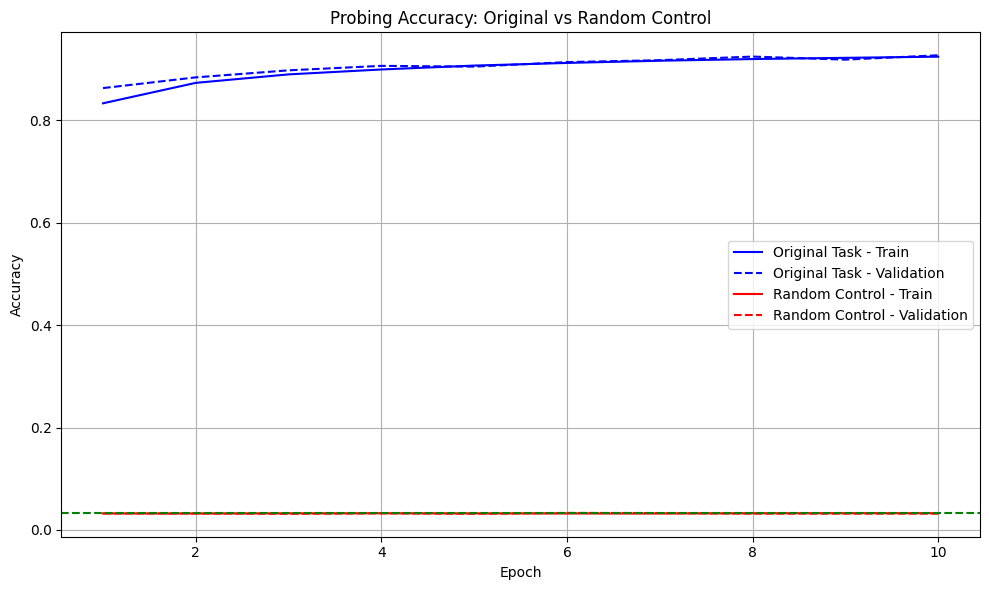

In [11]:
X, Y = create_dataset(model, data, "cpu")

# Create a control dataset with randomized labels
Y_random = torch.randint_like(Y, 0, Y.max().item() + 1)

# Train both the original and control probes
original_train_acc, original_val_acc = train_probe(X, Y, "Original")
random_train_acc, random_val_acc = train_probe(X, Y_random, "Control (Random)")

# Plot the results
plot_accuracies(original_train_acc, original_val_acc, random_train_acc, random_val_acc)

In [12]:
class ProbingClassifierAblation(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128, n_layers=1):
        super(ProbingClassifierAblation, self).__init__()
        self.n_layers = n_layers
        self.linear = nn.Linear(input_size, output_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.fc5 = nn.Linear(hidden_size, 256)
        self.fc6 = nn.Linear(256, output_size)
        self.fc7 = nn.Linear(256, hidden_size)
        self.fc8 = nn.Linear(256, 256)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        if self.n_layers == 0:
            out = self.linear(x)
        elif self.n_layers == 1:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc4(out)
        elif self.n_layers == 2:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc4(out)
        elif self.n_layers == 3:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc3(out)
            out = self.relu(out)
            out = self.fc4(out)
        elif self.n_layers == 4:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc5(out)
            out = self.relu(out)
            out = self.fc8(out)
            out = self.relu(out)
            out = self.fc7(out)
            out = self.relu(out)
            out = self.fc4(out)
        return out
        
def train_probe_ablation(X, Y, model_name="original", num_epochs=10, batch_size=32, learning_rate=0.001, n_layers = 1):
    input_size = X.shape[1]
    num_classes = Y.max().item() + 1
    print(f"Input Size: {input_size}, Num Classes: {num_classes}")
    
    dataset = TensorDataset(X, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    probing_model = ProbingClassifierAblation(input_size, num_classes, n_layers=n_layers).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(probing_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        probing_model.train()
        train_correct = 0
        train_total = 0
        train_loss = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = probing_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == targets).sum().item()
            train_total += targets.size(0)
        
        # Validation phase
        probing_model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = probing_model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)
        
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        scheduler.step(avg_val_loss)
        
        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print("-------------------")
    
    return train_accuracies, val_accuracies

In [14]:
traintaskm0, valtaskm0 = train_probe_ablation(X, Y, "Original", n_layers=0)
reainrandomm0, valrandomm0 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=0)
tm0 = max(traintaskm0)
vm0 = max(valtaskm0)
rm0 = max(reainrandomm0)
rv0 = max(valrandomm0)

traintaskm1, valtaskm1 = train_probe_ablation(X, Y, "Original", n_layers=1)
trainrandomm1, valrandomm1 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=1)
tm1 = max(traintaskm1)
vm1 = max(valtaskm1)
rm1 = max(trainrandomm1)
rv1 = max(valrandomm1)

traintaskm2, valtaskm2 = train_probe_ablation(X, Y, "Original", n_layers=2)
trainrandomm2, valrandomm2 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=2)
tm2 = max(traintaskm2)
vm2 = max(valtaskm2)
rm2 = max(trainrandomm2)
rv2 = max(valrandomm2)

traintaskm3, valtaskm3 = train_probe_ablation(X, Y, "Original", n_layers=3)
trainrandomm3, valrandomm3 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=3)
tm3 = max(traintaskm3)
vm3 = max(valtaskm3)
rm3 = max(trainrandomm3)
rv3 = max(valrandomm3)

traintaskm4, valtaskm4 = train_probe_ablation(X, Y, "Original", n_layers=4)
trainrandomm4, valrandomm4 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=4)
tm4 = max(traintaskm4)
vm4 = max(valtaskm4)
rm4 = max(trainrandomm4)
rv4 = max(valrandomm4)

Input Size: 32, Num Classes: 31
Original - Epoch [1/10]
Train Loss: 0.6146, Train Accuracy: 0.7919
Val Loss: 0.5555, Val Accuracy: 0.7974
-------------------
Original - Epoch [2/10]
Train Loss: 0.5435, Train Accuracy: 0.8012
Val Loss: 0.5412, Val Accuracy: 0.7983
-------------------
Original - Epoch [3/10]
Train Loss: 0.5348, Train Accuracy: 0.8028
Val Loss: 0.5361, Val Accuracy: 0.8020
-------------------
Original - Epoch [4/10]
Train Loss: 0.5306, Train Accuracy: 0.8033
Val Loss: 0.5314, Val Accuracy: 0.8057
-------------------
Original - Epoch [5/10]
Train Loss: 0.5282, Train Accuracy: 0.8037
Val Loss: 0.5314, Val Accuracy: 0.7994
-------------------
Original - Epoch [6/10]
Train Loss: 0.5262, Train Accuracy: 0.8041
Val Loss: 0.5284, Val Accuracy: 0.8037
-------------------
Original - Epoch [7/10]
Train Loss: 0.5253, Train Accuracy: 0.8039
Val Loss: 0.5274, Val Accuracy: 0.8037
-------------------
Original - Epoch [8/10]
Train Loss: 0.5242, Train Accuracy: 0.8043
Val Loss: 0.5283, V

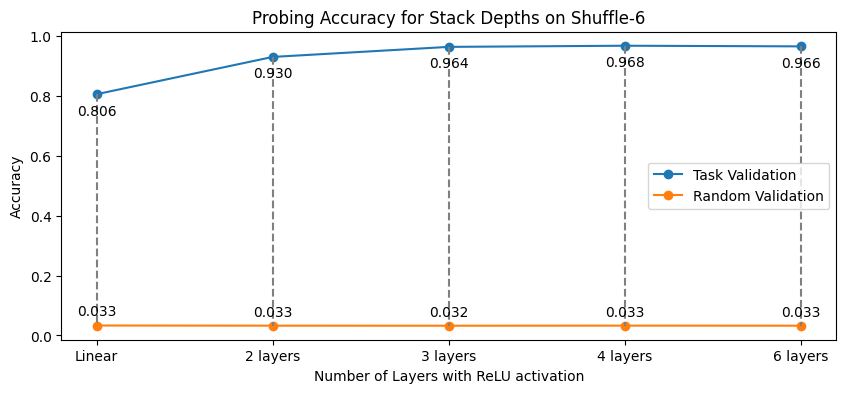

In [16]:
import matplotlib.pyplot as plt

# Define the lists
task_train = [tm0, tm1, tm2, tm3, tm4]
task_val = [vm0, vm1, vm2, vm3, vm4]
random_train = [rm0, rm1, rm2, rm3, rm4]
random_val = [rv0, rv1, rv2, rv3, rv4]

plt.figure(figsize=(10, 4))
# plt.plot(task_train, label='Task Train', marker='o')
plt.plot(task_val, label='Task Validation', marker='o')
# plt.plot(random_train, label='Random Train', marker='o')
plt.plot(random_val, label='Random Validation', marker='o')

# Add vertical lines between corresponding points of task_val and random_val
for i, (tv, rv) in enumerate(zip(task_val, random_val)):
    plt.vlines(x=i, ymin=tv, ymax=rv, colors='gray', linestyles='dashed')

for i, (tv, rv) in enumerate(zip(task_val, random_val)):
    plt.annotate(f'{tv:.3f}', (i, tv), textcoords="offset points", xytext=(0,-15), ha='center')
    plt.annotate(f'{rv:.3f}', (i, rv), textcoords="offset points", xytext=(0,7), ha='center')

# Add labels and title
plt.xlabel('Number of Layers with ReLU activation')
plt.ylabel('Accuracy')
plt.title('Probing Accuracy for Stack Depths on Shuffle-6')

# Add a legend
plt.legend()

# Set x-axis labels
plt.xticks([0, 1, 2, 3, 4], ['Linear', '2 layers', '3 layers', '4 layers', '6 layers'])
plt.savefig('shuffle6.png', dpi=300)
# Display the plot
plt.show()